# Imports

In [1]:
import sys
sys.path.append("src/datasets")

import pandas as pd
import logging
from src.datasets.merge_movie_lens import merge_movie_lens
from src.datasets.imdb_management import ImdbSearcher
from src.datasets.extract_movielens_to_imdb_mapping import get_tconst_by_title
from src.datasets.augment_movielens import *

# Data preparation

## Select data

### Select data source

#### MovieLens 1M
The MovieLens 1M is our main dataset. It has three files: ratings.dat, users.dat, movies.dat.
1. First file contains the information about the films' ratings entered by users and corresponding timestamps.
2. Second file provides the data about users' genders, ages, occupations, zip-codes.
3. Third one gives info about movies: titles and genres.

MovieLens 1M dataset is provided here: https://grouplens.org/datasets/movielens/1m/.

#### IMDB
The IMDB datasets provide much information about different movies and series. We use it to augment existing model with movies features and get better quality of the recommender system. 

1. The first dataset "title.basics.tsv.gz" is the entrypoint dataset with various information. First, it matches titles to their inner IMDB identifiers, which are necessary to navigate other datasets. We use this to integrate IMDB data into movielens data. Second, it contains information about title genres, which is used further.
2. The second dataset "title.crew.tsv.gz" contains information about title directors, which will further be used for feature construction.
3. Finally, "title.ratings.tsv.gz" provides information about title average ratings and number of votes given to them.

IMDB datasets are provided by IMDB itself: https://datasets.imdbws.com

In [2]:
from src.datasets.download_imdb import load_imdb_datasets

In [3]:
load_imdb_datasets()

[██████████████████████████████████████████████████]
Decompressing... Removing...
[██████████████████████████████████████████████████]
Decompressing... Removing...
[██████████████████████████████████████████████████]
Decompressing... Removing...


### Select attributes and records

#### Movie attributes
Movie attributes are taken from IMDB dataset.
- **Ratings:** We use ratings statistics from IMDB dataset. Ratings statistic includes average rating over different users, and number of votes for the film. Average movie rating by itself is a great approximator for each particular user-movie interaction, it's applicability is obvious. Further, we've considered the number of votes to be a representative statistics for the film popularity, which in turn can be a good feature for the recommender system. 
- **Genres:** We also use information about the film genre. Genre is a categorical value and its processing is explained further.

#### User attributes
Further we go to the user features. All user features come from the MovieLens dataset
- **Age:** The MovieLens dataset provides this information about users, and obviously the user age can explain a substantial part of variance in user preferences. So we use it.
- **Occupation:** What does the user do to not die from hunger. Occupation largely influences the interests, so we use it.
- **Gender:** Also influences the interest, so we use it too.

#### Records
The IMDB contains extensive amount of records for every at-least-slightly popular title, which are not presented in the movielens dataset. Only a small subset of titles, which are presented in the MovieLens dataset is used

## Clean data
Before starting the project we have carefully investigated different sources of data and have chosen those that are the most exhaustive and exact. Thus, the data is clean and there is no need to clean it more.

## Construct data

#### Top directors
This step gives us 1 new feature stating whether top director is involved in a particular film.

In [4]:
movielens = pd.read_csv("data/movie_lens/movie_lens_1m.csv")

In [6]:
augmented_movielens = add_top_directors(movielens)

In [7]:
print(f"Fraction of movies created by popular directors is {round(augmented_movielens.topDirectorMovie.mean() * 100, 1)}%")

Fraction of movies created by popular directors is 12.1%


#### Movie attributes
- **Ratings:** The number of votes comes from a distribution with a very heavy right tail, that makes the feature hard to use for linear models (which our recommender system is). Thus, during the augmentation procedure we apply log scaling for the feature. 

#### User attributes
- **Age:** The movielens dataset has only a few unique values for the ages, they presumably were splitted to several bins. This decision is quite useful for our system, as the dependency between the user age and their preferences is not really linear, so we will one-hot encode these values. However, we also add the log value of the user age (just in case :O, there is no such a notion of "too much features").

## Integrate data

### Matching IMDB titles to Movielens titles

Before augmenting the movielens dataset with IMDB titles we need to establish one-to-one correspondence between titles in these datasets. 

As soon as titles are written in a slightly different ways, some manual string processing was applyed. This includes removing the year from the title and moving articles "A", "The" to the beginning of the string.

In [8]:
imdb = pd.read_csv("data/imdb/title.basics.tsv", sep='\t')
imdb['originalTitle'] = imdb.originalTitle.astype(str)
imdb['startYear'] = imdb.startYear.astype(str)

searcher = ImdbSearcher(imdb)
title_to_imdb_id = pd.read_csv("data/movielens_to_imdb_mapping.csv")
# title_to_imdb_id = pd.DataFrame({"title": movielens.Title.unique()})
# title_to_imdb_id['tconst'] = title_to_imdb_id.title.progress_apply(get_tconst_by_title, args=[searcher])
# title_to_imdb_id.to_csv("data/movielens_to_imdb_mapping.csv", index=False)
title_to_imdb_id.head()

/var/folders/hz/1_mmtrjd4w313qt1k1grktpc0000gn/T/ipykernel_8153/1772739270.py:1: DtypeWarning: Columns (4,5) have mixed types. Specify dtype option on import or set low_memory=False.
  imdb = pd.read_csv("data/imdb/title.basics.tsv", sep='\t')


,title,tconst
0,One Flew Over the Cuckoo's Nest (1975),tt0073486
1,James and the Giant Peach (1996),tt0116683
2,My Fair Lady (1964),tt0058385
3,Erin Brockovich (2000),tt0195685
4,"Bug's Life, A (1998)",tt0120623


The resulting dataframe is further used for IMDB features integration to the MovieLens dataset.

## Format data

#### Convert initial MovieLens' .dat files to .csv files and merge these .csv files
We have decided to convert source `.dat` files to the `.csv` format since it is more convenient for us to work with Dataframes rather than with raw text files. Furthermore, `.csv` format allows us to do data analysis and preprocessing more easily.

In [9]:
merge_movie_lens()

INFO:root:Converting movies file to .csv format...
INFO:root:Converting ratings file to .csv format...
INFO:root:Converting users file to .csv format...
INFO:root:Merging the dataframes...
INFO:root:Data is ready.


#### Movie data
- **Genres:** One movie may have several genres, and the genre is a categorial value, so we make a bitmask for each film, which has 1 if the movie belongs to the corresponding genre. The augmentation gives us 18 feature columns for the film.

#### User data
- **Age:** again just make a bitmask, encoding the user age. For this feature, one user may have only one age value, so it basically becomes one-hot encoding (OHE).
- **Occupation:** Next, we encode the occupation of users. Again, we create a bitmask which is basically OHE. Twenty one new feature columns.
- **Gender:** Finally, the gender. We were brave enough to binarize this value. One new feature, one more column.

## Apply Selection + Construction + Integration + Formatting

#### Movie Ratings
This step gives us 2 features, average movie rating and log of the number of votes

In [10]:
augmented_movielens = augment_with_ratings(augmented_movielens)

As it was discussed above, the log-scaled number of votes may be a good feature for our linear model. Observe the nearly-normal distribution obtained for this feature.

<AxesSubplot:title={'center':'Logarithm of Num votes distribution'}, ylabel='Frequency'>

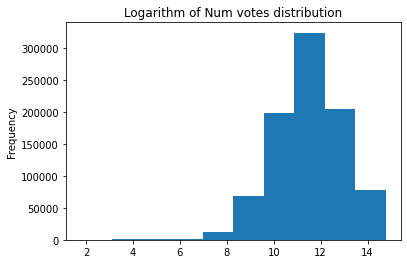

In [11]:
augmented_movielens.logNumVotesMovie.plot.hist(title="Logarithm of Num votes distribution")

#### Movie genres

Thi step gives 7 feature columns

In [12]:
augmented_movielens = encode_bitmask_genres(augmented_movielens)

<AxesSubplot:title={'center':'Genre feature distribution'}>

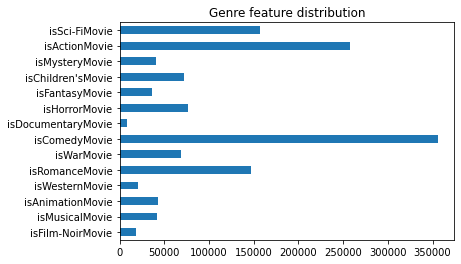

In [13]:
augmented_movielens.loc[:, "isFilm-NoirMovie":].sum(axis=0).plot.barh(title="Genre feature distribution")

#### User ages

This step gives us 8 feature columns.

In [14]:
augmented_movielens = encode_ohe_age(augmented_movielens)

<AxesSubplot:title={'center':'Age feature distribution'}>

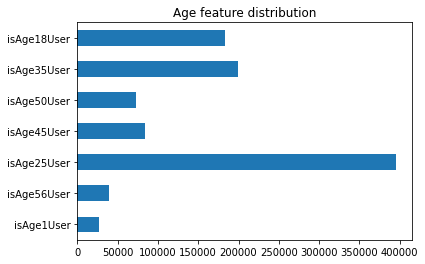

In [15]:
augmented_movielens.iloc[:, -7:].sum(axis=0).plot.barh(title="Age feature distribution")

#### Users' occupation
This step gives 21 feature columns

In [16]:
augmented_movielens = encode_ohe_occupation(augmented_movielens)

<AxesSubplot:title={'center':'Users occupation statistics'}>

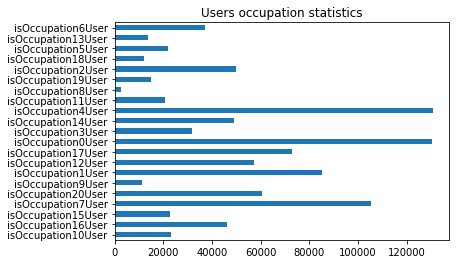

In [17]:
augmented_movielens.loc[:, "isOccupation10User":].sum(axis=0).plot.barh(title="Users occupation statistics")

#### Users' genders
Just one feature column

In [18]:
augmented_movielens = process_gender(augmented_movielens)

In [19]:
print(f"The {round(100 * augmented_movielens.GenderUser.mean(), 1)} of the users self-identify as men")

The 75.4 of the users self-identify as men


In [20]:
augmented_movielens.columns

Index(['UserID', 'MovieID', 'Rating', 'Timestamp', 'Title', 'ZipCode',
       'topDirectorMovie', 'averageRatingMovie', 'logNumVotesMovie',
       'isDramaMovie', 'isAdventureMovie', 'isThrillerMovie', 'isCrimeMovie',
       'isFilm-NoirMovie', 'isMusicalMovie', 'isAnimationMovie',
       'isWesternMovie', 'isRomanceMovie', 'isWarMovie', 'isComedyMovie',
       'isDocumentaryMovie', 'isHorrorMovie', 'isFantasyMovie',
       'isChildren'sMovie', 'isMysteryMovie', 'isActionMovie', 'isSci-FiMovie',
       'logAgeUser', 'isAge1User', 'isAge56User', 'isAge25User', 'isAge45User',
       'isAge50User', 'isAge35User', 'isAge18User', 'isOccupation10User',
       'isOccupation16User', 'isOccupation15User', 'isOccupation7User',
       'isOccupation20User', 'isOccupation9User', 'isOccupation1User',
       'isOccupation12User', 'isOccupation17User', 'isOccupation0User',
       'isOccupation3User', 'isOccupation14User', 'isOccupation4User',
       'isOccupation11User', 'isOccupation8User', 'isOccupa

## Save the preprocessed data

In [21]:
augmented_movielens.to_csv("data/augmented_movie_lens.csv", index=False)